## Setup

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

## Get the data - features and **target**

In [4]:
import os
from pathlib import Path

# Load data
path = Path(os.getcwd() + "/..").resolve()
dataset_path = path/'Datasets/Tabular/FOOD-DATA-GROUP.csv'
df = pd.read_csv(dataset_path)
print(dataset_path)

df = df.drop("food", axis=1)
features = df.drop("Caloric Value", axis=1).columns.tolist()
target = "Caloric Value"

/Users/yashicajain/Documents/F21DL/Coursework/CourseWork/Datasets/Tabular/FOOD-DATA-GROUP.csv


The data is skewed. Transformation is needed to get a more normally distributed data.

## Yeo-Johnson transformation

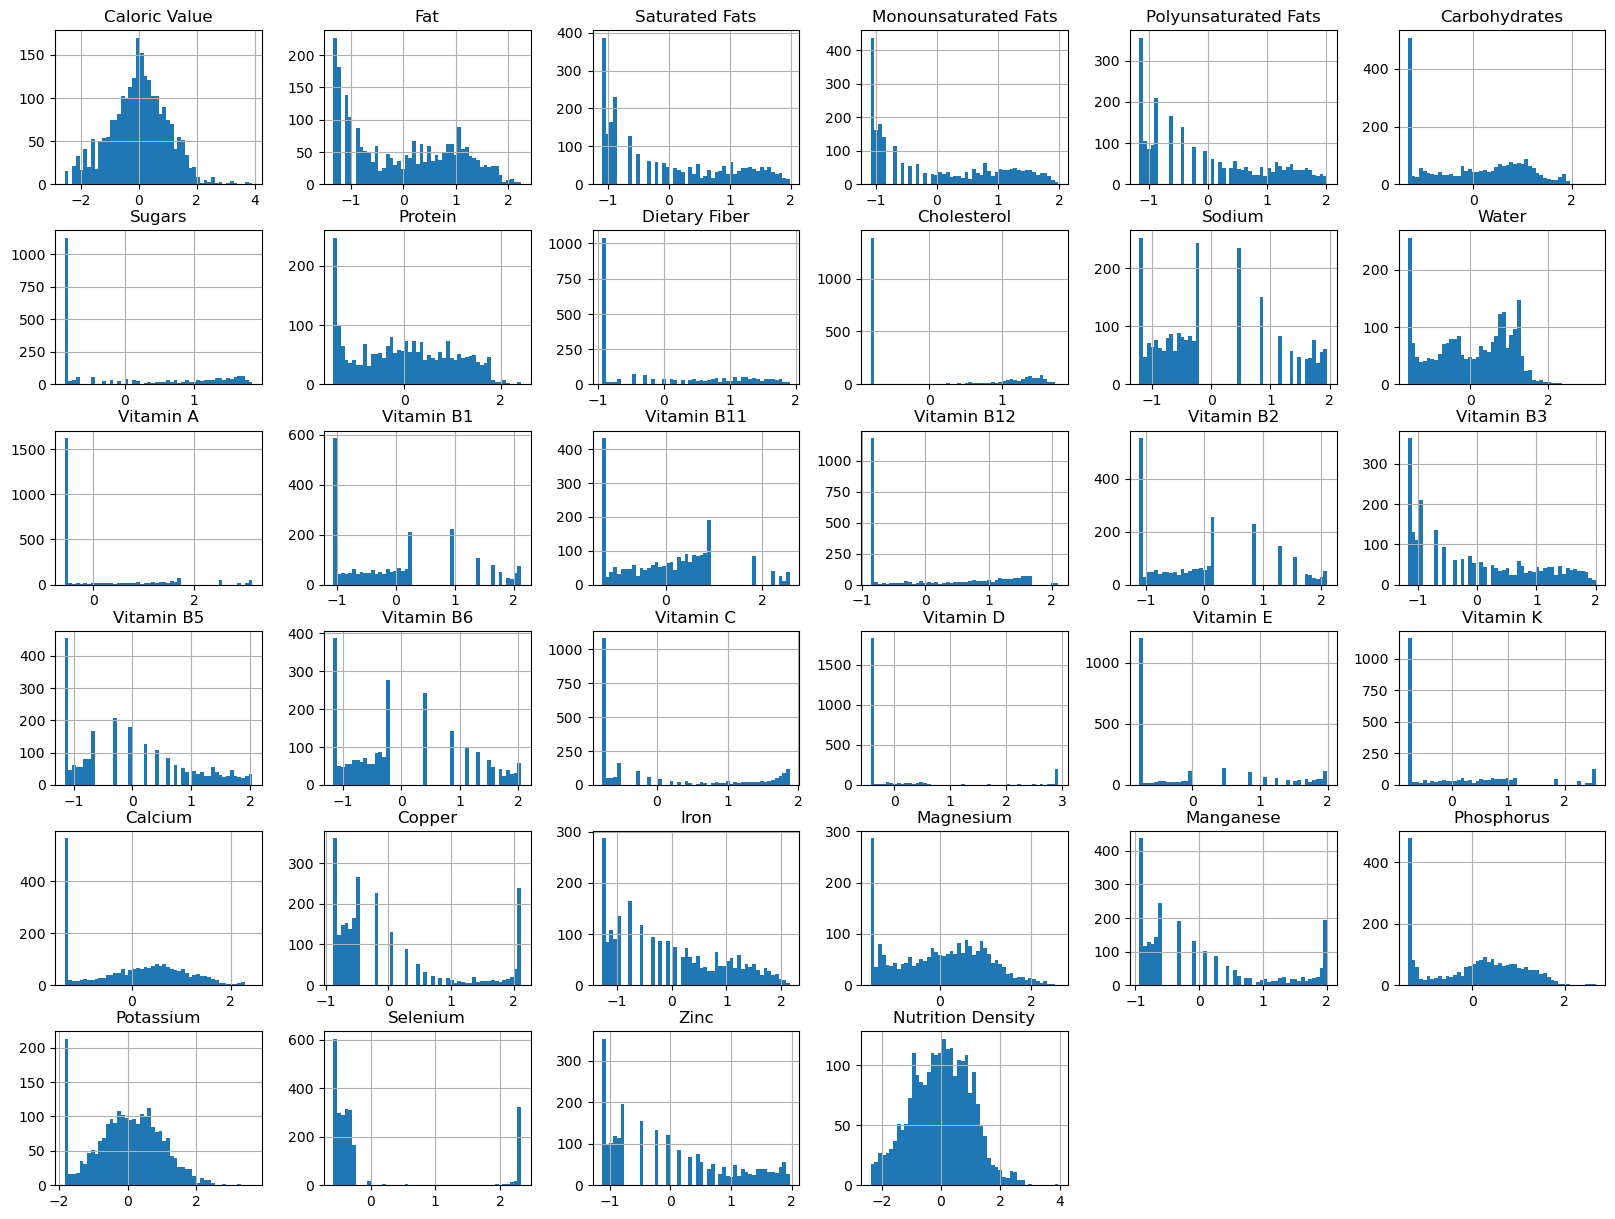

In [7]:
from sklearn.preprocessing import PowerTransformer

# Initialize the PowerTransformer
pt = PowerTransformer(method='yeo-johnson', standardize=True)

# Transform the data
df_transformed = pt.fit_transform(df)

# Convert back to DataFrame
df = pd.DataFrame(df_transformed, columns=df.columns)

# Visualizing the transformed data
df.hist(bins=50, figsize=(20,15))
plt.show()

Find correlation between features and target
## Pearson's correlation coefficient

In [9]:
# Get the correlation of features with the target
corr = df.corr()[target].sort_values(ascending=False)[1:]

# Absolute for positive values
abs_corr = abs(corr)

# Consider all features with more than 0.1 correlation with the target
relevant_features = abs_corr[abs_corr>0.1]
new_df = df[relevant_features.index]
features = new_df.columns.tolist()

print(features)

['Nutrition Density', 'Fat', 'Protein', 'Polyunsaturated Fats', 'Saturated Fats', 'Monounsaturated Fats', 'Zinc', 'Iron', 'Vitamin B3', 'Potassium', 'Phosphorus', 'Vitamin B5', 'Magnesium', 'Vitamin B1', 'Vitamin B2', 'Vitamin B6', 'Calcium', 'Cholesterol', 'Sodium', 'Water', 'Carbohydrates', 'Vitamin E', 'Vitamin A', 'Vitamin B11', 'Dietary Fiber', 'Copper', 'Manganese', 'Vitamin B12', 'Selenium', 'Vitamin D']



## Feature Extraction


### Create features manually

In [12]:
df['Protein+Carbohydrates+Fat'] = df['Protein']+df['Carbohydrates']+df['Fat']
df['Total Fats'] = df['Polyunsaturated Fats'] + df['Saturated Fats'] + df['Monounsaturated Fats']

new_features = ['Protein+Carbohydrates+Fat', 'Total Fats']

### Correlation matrix

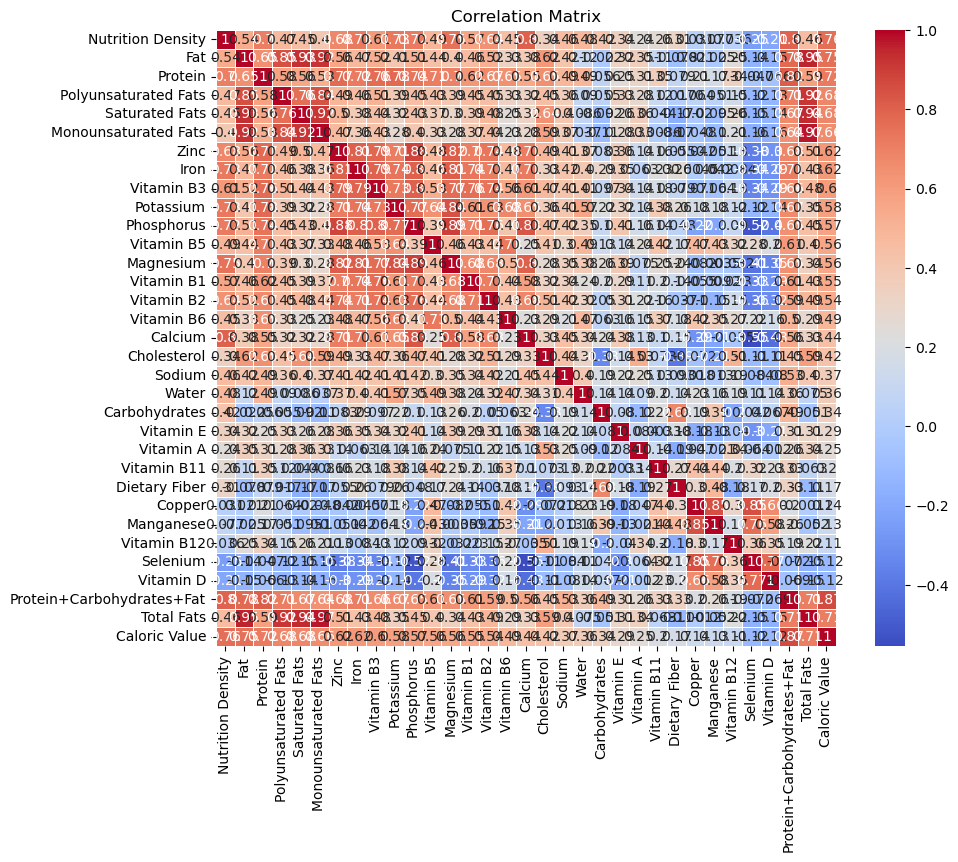

In [14]:
import numpy as np
X = df[features + new_features]
y = df[target]
feature_names = np.array(X.columns)
corr = df[np.concatenate((feature_names, [target]))].corr()

import matplotlib.pyplot as plt
import seaborn as sns

### Heatmap visualization
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

Remove features correlated with other features

In [16]:
features = ['Nutrition Density', 'Zinc', 'Vitamin B3', 'Vitamin B1', 'Vitamin B6', 'Calcium', 'Cholesterol', 'Sodium', 'Water', 'Dietary Fiber', 'Sugars', 'Vitamin C', 'Selenium' ]

### Extract top 10 features

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import root_mean_squared_error, r2_score

feature_selector = SequentialFeatureSelector(
       LinearRegression(),
       n_features_to_select=10,
       direction="backward",
       scoring="r2",
       tol=-1e-4,
       n_jobs=-1,
)
model = make_pipeline(feature_selector, LinearRegression())
model.fit(X, y)
selected_features = feature_selector.get_support()
print(f"Features selected: {feature_names[selected_features]}")

predictions = model.predict(X)
mse = root_mean_squared_error(y, predictions)
r2 = r2_score(y, predictions)

print(f"Root Mean Squared Error: {mse:.3f}")
print(f"R² Score: {r2:.3f}")

Features selected: ['Nutrition Density' 'Monounsaturated Fats' 'Phosphorus' 'Calcium'
 'Sodium' 'Vitamin B11' 'Dietary Fiber' 'Copper' 'Selenium'
 'Protein+Carbohydrates+Fat']
Root Mean Squared Error: 0.353
R² Score: 0.875
